In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os

# Change this depending on your data.
taxonomic_rank = 'Genus'
base_path = "pipelines/camisimGI/wgsa/"
rel_abund_file = "2_genus_relabund.csv"
program_name = "WGSA2"
sample_id = "s2"

expected_input = "pipelines/camisimGI/s2_expected.csv"

In [ ]:
# Generate the expected result from the tsv file. Returns a dataframe.
def generate_expected(input_path: str, plot: bool = False) -> pd.DataFrame:
    expected = pd.read_csv(input_path, sep='\t', index_col=0, names=['Organism', 'Counts'], header=0)
    expected = expected[['Counts']].astype(int)

    # Calculate expected relative abundance.
    expected['RA'] = expected['Counts'] / expected['Counts'].sum()

    # Let's split the organism index into two columns to find the genera.
    orgs = expected.index.to_list()
    genus = [org.strip().split(' ')[0] for org in orgs]
    genus = [x.replace('M.', 'Micromonospora') for x in genus]

    # Apparently, propionibacterium have been renamed to cutibacterium.
    genus = [x.replace('Propionibact.', 'Cutibacterium') for x in genus]

    # Add the columns to the dataframe.
    expected['Genus'] = genus
    # display(expected.head(12))

    # Group by genus and sum the counts for overlapping genera.
    exp_genus = expected.groupby('Genus').sum()
    exp_genus.sort_values('RA', ascending=False, inplace=True)

    if plot:
        exp_genus.plot.bar(y='RA', figsize=(8, 5), legend=False, title='Expected Relative Abundance')
    
    return exp_genus

# Use generate_expected to generate the expected result for the bmock12 data.
# exp_genus = generate_expected('expected.tsv')

# For camisim, we can just read the csv in directly.
exp_genus = pd.read_csv(expected_input, index_col=0, names=['Genus', 'RA'], header=0)
exp_genus = exp_genus.where(exp_genus['RA'] > 0.001).dropna()

In [ ]:
def generate_experimental_df(input_path: str, index_name: str) -> pd.DataFrame:
    # Now, load in the experimental values.
    r_genus = pd.read_csv(input_path, index_col=0, names=[index_name, "RA"], header=0)
    # display(r_genus.head(12))
    r_genus = r_genus[['RA']].astype(float)

    return r_genus

# Instead, let's concat the two dataframes into long format and add a column from where it originated.
def long_format(df1, df2):
    merged = pd.concat([df1, df2], axis=0)

    # !!! This is slick
    merged['Source'] = ['Expected'] * len(df1) + ['Observed'] * len(df2)

    return merged

result_genus = generate_experimental_df(os.path.join(base_path, rel_abund_file), taxonomic_rank)
# display(result_genus.head(12))
merged = long_format(exp_genus, result_genus)

In [ ]:
from scipy.stats import chisquare

# Perform chi-square test on the observed and expected values.
def chi_square_test(df: pd.DataFrame):
    # Perform chi-square test on the observed and expected values.
    chi2, p = chisquare(df['RA_y'], df['RA_x'])
    return chi2, p

def linear_regression(df: pd.DataFrame, plot: bool = False, save_path: str = None) -> pd.DataFrame:
    # Merge on the genus key for easy plotting. The expected results are on the left, the observed on the right.
    # linear_df = exp_genus.merge(df, left_index=True, right_index=True)

    # try join because the left merge will drop the genera that are not in the observerd results, but we want to show that the experimental missed it.
    linear_df = exp_genus.join(df, how='left', lsuffix='_x', rsuffix='_y')
    linear_df.fillna(0, inplace=True)

    # Linear regression with scikit.
    X = linear_df['RA_x'].values.reshape(-1, 1)
    Y = linear_df['RA_y'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, Y)
    y_pred = reg.predict(X)

    # Scatter plot of RA_x vs. RA_y.
    if plot:
        fig = plt.figure(figsize=(10, 8))
        plt.scatter(linear_df['RA_x'], linear_df['RA_y'], color='black')

        # Calculate mean absolute error.
        mae = np.mean(np.abs(linear_df['RA_x'] - linear_df['RA_y']))

        # Regression line.
        plt.plot(X, y_pred, color='red', linewidth=2)
        # Labels.
        plt.xlabel('Expected Relative Abundance')
        plt.ylabel('Observed Relative Abundance')
        plt.title(f'Expected vs. Observed Relative Abundance for {program_name} {taxonomic_rank}')

        # Add r^2 value.
        plt.text(0.1, 0.9, f'r^2 = {reg.score(X,Y):.4f}', transform=plt.gca().transAxes)
        # Add MAE.
        plt.text(0.1, 0.85, f'MAE = {mae:.4f}', transform=plt.gca().transAxes)

        # Add line y = x.
        plt.plot([0, 1], [0, 1], color='blue', linewidth=2, linestyle='--')

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    return linear_df
    
linear_regression(result_genus, plot=True, save_path=os.path.join(base_path, f"{sample_id}_bivariate_{taxonomic_rank}.png"))

In [240]:
# Bar plot of RA_x vs. RA_y side by side.
# sns.set_style("whitegrid")
def bar_plot(df: pd.DataFrame, plot: bool = False, save_path: str = None):
    subset = pd.DataFrame()

    for x, y in df.groupby(taxonomic_rank):
        if y["Source"].values[0] == "Expected":
            subset = pd.concat([y, subset], axis=0)

    subset = subset.where(subset['RA'] > 0.001).dropna()

    if plot:
        # Plot a category bar chart with the colors besed on the source.
        fig = plt.figure(figsize=(10, 8))
        ax = sns.barplot(x=subset.index, y='RA', hue='Source', data=subset, errorbar=None)
        # ax.bar_label(ax.containers[0], fmt='%.2e', label_type='center')
        # ax.bar_label(ax.containers[1], fmt='%.2e', label_type='edge')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_title(f'Expected vs. Observed Relative Abundance for {program_name} ({taxonomic_rank})')
        ax.set_xlabel('Genus')
        ax.set_ylabel('Relative Abundance')

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# bar_plot(merged, plot=True, save_path=os.path.join(base_path, f"{sample_id}_bars_{taxonomic_rank}.png"))

In [ ]:
# We will now aggregate the differences by pipeline. To do this, we will start at the root and walk down, looking for "relabund" files.
root_dir = "pipelines/camisimGI/"

def get_all_expected(root_dir: str):
    combined_expected = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if "expected.csv" in f:
                df = pd.read_csv(os.path.join(root, f), index_col=0, names=['Genus', 'RA'], header=0)
                combined_expected = pd.concat([combined_expected, df], axis=0)

    combined_expected["Source"] = "Expected"

    # Files are of s#_expected.csv, so we can split on the underscore and take the first part.
    combined_expected["SampleID"] = f.split("_")[0]

    return combined_expected

In [ ]:
def get_relabund_files(root_dir: str):
    combined_df = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if "relabund" and "genus" in f:
                p = os.path.join(root, f)
                exp = generate_experimental_df(p, taxonomic_rank)

                # Add a column to the experimental dataframe with the pipeline name.
                exp['Source'] = os.path.dirname(p).split('/')[-1]

                # Add sampleID to the experimental dataframe.
                exp['SampleID'] = os.path.basename(p).split('_')[0]

                # Add the experimental dataframe to the combined dataframe.
                combined_df = pd.concat([combined_df, exp], axis=0)

    return combined_df


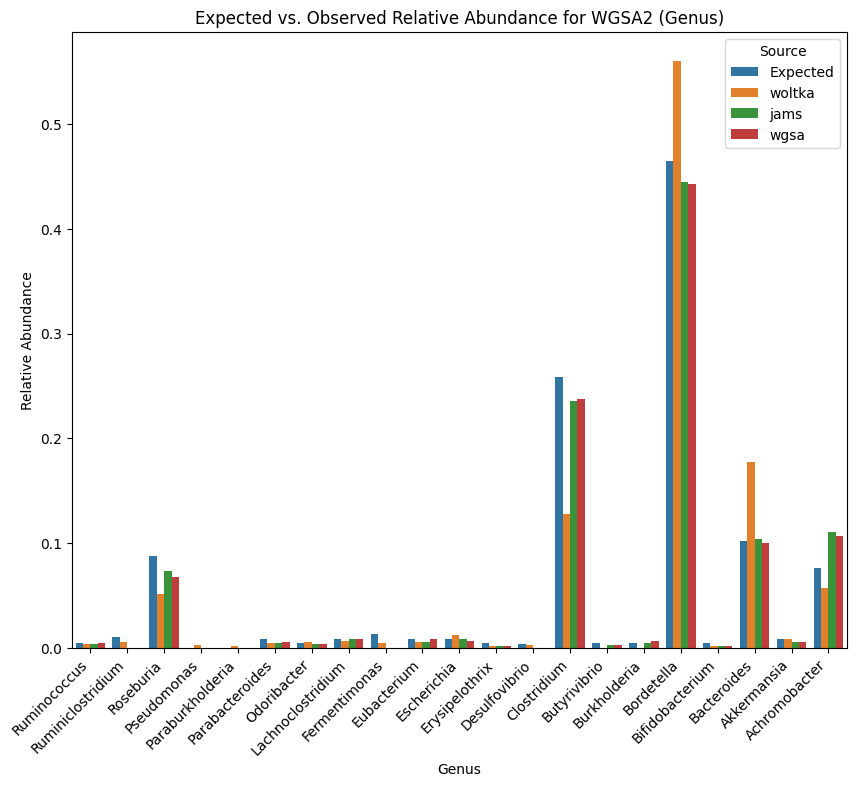

In [241]:
def fully_combined():
    combined_df = get_relabund_files(root_dir)
    combined_expected = get_all_expected(root_dir)

    # Merge the expected and experimental dataframes.
    merged = pd.concat([combined_expected, combined_df], axis=0)
    merged = merged.reset_index()
    merged = merged.rename(columns={'index': 'Genus'})
    merged = merged.set_index('Genus')

    return merged

full_df = fully_combined()
bar_plot(full_df, plot=True, save_path=os.path.join(base_path, f"{sample_id}_bars_{taxonomic_rank}_all.png"))

In [ ]:
# Multiple linear regression plot using seaborn.
# We need to pivot the dataframe so that the genus is the index 